## Import modules

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

#adding to sys.path the directory for WRFChem Toolit code.
import sys
sys.path.insert(0,'/exports/csce/datastore/geos/users/s1878599/python_code')
from WRFChemToolkit.analysis import aerosols as ar

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data and merge
datapath='/scratch/local/s1878599/outputs/BB_season2017_16cores_rebus_intel/wrfout_*'
ds = xr.open_mfdataset(datapath)

In [3]:
datapath_nofire='/scratch/local/s1878599/outputs/BB_season2017_16cores_rebus_intel_NO_FIRE/wrfout_*'
ds_nofire = xr.open_mfdataset(datapath_nofire)

## Define useful functions


In [4]:
#Defining functions for analysis

def var_space_mean(ds):
 """
  Make the average over 'xlat and xlong' dimension of a datarray.

  :param da:
    datarray to be averaged.
  :type da: xarray DataArray.
  :return:
    Time averaged da.
  :rtype: xarray DataSet.
 """
 return xr.Dataset(dict(ds.mean(dim= ['south_north','west_east'],keep_attrs=True).data_vars), coords=dict(ds.coords))

def timeavg(ds):
    """
      Make the average over 'time' dimension of a datarray.
    """
    return xr.Dataset(dict(ds.mean(dim='Time', keep_attrs=True).data_vars), coords = dict(ds.coords))


def space_subset(dataset, lat_lim, long_lim ):
    """
    Extract spatial subset of data given lat and long limits.
    """
    
    s_subset=ds.where((long_lim[0] < ds.XLONG) & (ds.XLONG < long_lim[1]) & (lat_lim[0] < ds.XLAT) & (ds.XLAT < lat_lim[1]), drop=True)
  
    return s_subset

In [5]:
#Defining functions for plot

from numpy import ma
from matplotlib import cbook
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader


class MidPointNorm(Normalize):    
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")       
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = ma.getmask(result)
                result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint            
            resdat[resdat>0] /= abs(vmax - midpoint)            
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = ma.array(resdat, mask=result.mask, copy=False)                

        if is_scalar:
            result = result[0]            
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if cbook.iterable(value):
            val = ma.asarray(value)
            val = 2 * (val-0.5)  
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0: 
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint


def var_plot_2D(dataset, var_name, level, maskvalue,title):
    
    var = dataset[var_name]
    
    #draw map
    ax = plt.subplot(projection=ccrs.PlateCarree())
    
    # draw coastlines and borders
    ax.add_feature(cfeature.COASTLINE,lw=0.75)
    ax.add_feature(cfeature.BORDERS, lw=0.75)
    
    
    # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
    fname = '/exports/csce/datastore/geos/users/s1878599/python_code/WRFChemToolkit/analysis/geo_data/gadm36_IND_shp/gadm36_IND_1.shp'   

    IND_provinces = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(IND_provinces, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.5,
                      lw=0.25)
    
    fname = '/exports/csce/datastore/geos/users/s1878599/python_code/WRFChemToolkit/analysis/geo_data/gadm36_PAK_shp/gadm36_PAK_1.shp'   

    PAK_provinces = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(PAK_provinces, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.5,
                      lw=0.25)
 
    #draw meridians and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.4, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}
    
    #plot SURFACE data
    long = dataset.XLONG.values[0,:,:]
    lat  = dataset.XLAT.values[0,:,:]
    
    if maskvalue == 'nomask':
        var_values = var[level,:,:].values
    else:
        var_values= np.ma.masked_where(var[level,:,:].values < maskvalue, var[level,:,:].values)  #mask values with conc less than 10 ug/m3
    
    res = 15 #controls the resolution for the map plotting.
    
    cmap= plt.cm.bwr    #plt.cm.OrRd# 
    norm = MidPointNorm(midpoint=0)
    cmap.set_bad(color='White')  # set masked values white.
    
    #cs = plt.pcolormesh(long, lat,var_values, cmap=cmap,transform=ccrs.PlateCarree(),norm=norm)
    cs= plt.contourf(long, lat, var_values,res,transform=ccrs.PlateCarree(),cmap=cmap, norm=norm)
    
    #colorbar
    cbar = plt.colorbar(cs) # pad=0.2 #format='%.2e'
    cbar.set_label(var.units)
    ax.set_title(title)
    
    #plotting parameters
    plt.rcParams['figure.figsize'] = [10, 5]
    

## Prepare data (add PM2.5 components, time average, space average)

In [6]:
#create dates array.
dates = pd.DatetimeIndex(ds.XTIME.values)

In [7]:
dates2 =  pd.DatetimeIndex(ds_nofire.XTIME.values)

In [8]:
#extract aerosols
aer_fire = ar.get_aerosols(ds)
aer_no_fire =ar.get_aerosols(ds_nofire)

In [9]:
#Timeaverage
aer_fire_tavg= timeavg(aer_fire)
aer_nofire_tavg = timeavg(aer_no_fire)

## Plot PM2.5 distribution with fire and no fire

ValueError: midpoint must be between maxvalue and minvalue.

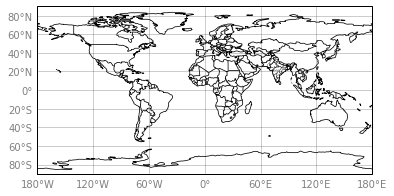

In [10]:
var_plot_2D(aer_fire_tavg, 'PM2_5_DRY', 0, 40,  'BASELINE-Surface PM2.5 average 18/10-16/11 2017')

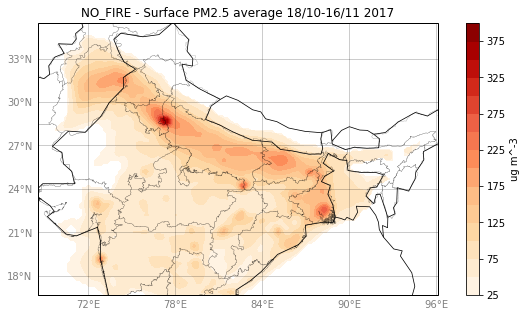

In [14]:
var_plot_2D(aer_nofire_tavg, 'PM2_5_DRY', 0, 40,  'NO_FIRE - Surface PM2.5 average 18/10-16/11 2017')

# Absolute and relative contribution of fires to PM2.5

## All PM2.5 

In [15]:
diff_PM25 = (aer_fire_tavg.PM2_5_DRY - aer_nofire_tavg.PM2_5_DRY).values

In [52]:
soa_diff = (aer_fire_tavg.pm25_SOA - aer_nofire_tavg.pm25_SOA).values

In [53]:
poa_diff = (aer_fire_tavg.pm25_POA - aer_nofire_tavg.pm25_POA).values

In [56]:
PM25_diff_timeavg = xr.Dataset({'PM2_5_DRY_diff': (['bottom_top','south_north','west_east'], diff_PM25),
                               'SOA_diff': (['bottom_top','south_north','west_east'], soa_diff),
                               'POA_diff': (['bottom_top','south_north','west_east'], poa_diff)},
                               
                               coords = dict(ds.coords))
PM25_diff_timeavg.PM2_5_DRY_diff.attrs['units'] = 'ug m-3'
PM25_diff_timeavg.SOA_diff.attrs['units'] = 'ug m-3'
PM25_diff_timeavg.POA_diff.attrs['units'] = 'ug m-3'

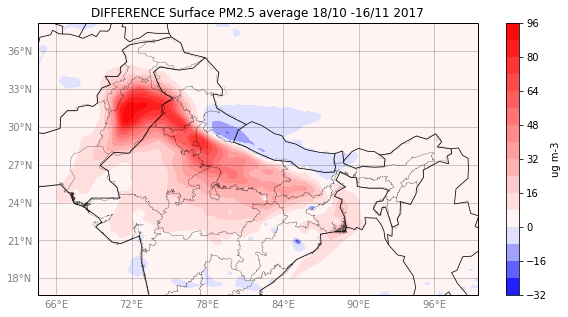

In [57]:
var_plot_2D(PM25_diff_timeavg, 'PM2_5_DRY_diff', 0,'nomask', 'DIFFERENCE Surface PM2.5 average 18/10 -16/11 2017')

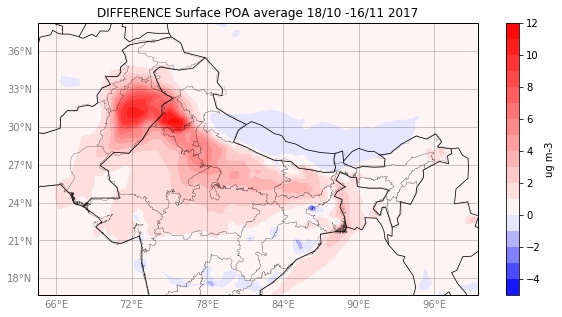

In [59]:
var_plot_2D(PM25_diff_timeavg, 'POA_diff', 0,'nomask', 'DIFFERENCE Surface POA average 18/10 -16/11 2017')

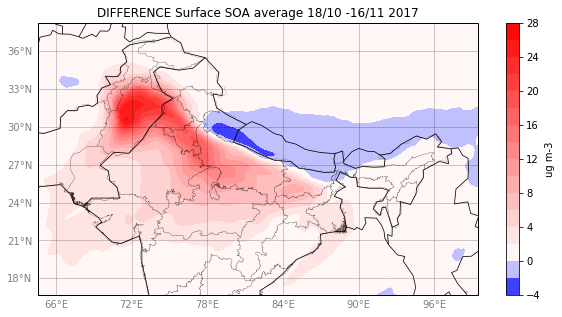

In [60]:
var_plot_2D(PM25_diff_timeavg, 'SOA_diff', 0,'nomask', 'DIFFERENCE Surface SOA average 18/10 -16/11 2017')